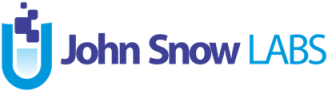

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/langtest/blob/main/demo/tutorials/RAG/RAG_HF.ipynb)

**LangTest** is an open-source python library designed to help developers deliver safe and effective Natural Language Processing (NLP) models. Whether you are using **John Snow Labs, Hugging Face, Spacy** models or **OpenAI, Cohere, AI21, Hugging Face Inference API and Azure-OpenAI** based LLMs, it has got you covered. You can test any Named Entity Recognition (NER), Text Classification, fill-mask, Translation model using the library. We also support testing LLMS for Question-Answering, Summarization and text-generation tasks on benchmark datasets. The library supports 60+ out of the box tests. For a complete list of supported test categories, please refer to the [documentation](http://langtest.org/docs/pages/docs/test_categories).

# Evaluate RAG with LlamaIndex + Langtest


In this notebook we will look into building an RAG pipeline and evaluating it with LlamaIndex + Langtest. It has following 2 sections.


*   Building RAG with LlamaIndex.
*   Evaluating RAG with **LlamaIndex + Langtest**.

## **Build RAG system**.
Let's build a simple RAG pipeline.

In [ ]:
!pip install llama-index

In [ ]:
import os
os.environ['OPENAI_API_KEY'] = "ADD YOUR KEY"

In [ ]:
import nest_asyncio

nest_asyncio.apply()

from llama_index.evaluation import generate_question_context_pairs
from llama_index import VectorStoreIndex, SimpleDirectoryReader, ServiceContext
from llama_index.node_parser import SimpleNodeParser
from llama_index.evaluation import generate_question_context_pairs
from llama_index.evaluation import RetrieverEvaluator
from llama_index.llms import OpenAI

import os
import pandas as pd

Let's use Paul Graham Essay text for building RAG pipeline.

**Download Data**

In [ ]:
!mkdir -p 'data/paul_graham/'
!curl 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/paul_graham/paul_graham_essay.txt' -o 'data/paul_graham/paul_graham_essay.txt'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75042  100 75042    0     0   260k      0 --:--:-- --:--:-- --:--:--  260k


**Load Data and Build Index.**

In [ ]:
from llama_index.embeddings import HuggingFaceEmbedding
from llama_index import ServiceContext, global_service_context, set_global_service_context

em = HuggingFaceEmbedding("BAAI/bge-small-en-v1.5")
servicecontext = ServiceContext.from_defaults(embed_model=em)

set_global_service_context(servicecontext)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Here we are using the **HuggingFaceEmbedding**

In [ ]:
documents = SimpleDirectoryReader("./data/paul_graham/").load_data()

# Define an LLM
llm = OpenAI(model="gpt-3.5-turbo")

# Build index with a chunk_size of 512
node_parser = SimpleNodeParser.from_defaults(chunk_size=512)
nodes = node_parser.get_nodes_from_documents(documents)
vector_index = VectorStoreIndex(nodes)

In [ ]:
vector_index.service_context.embed_model

HuggingFaceEmbedding(model_name='BAAI/bge-small-en-v1.5', embed_batch_size=10, callback_manager=<llama_index.callbacks.base.CallbackManager object at 0x7b73e7b60670>, tokenizer_name='BAAI/bge-small-en-v1.5', max_length=512, pooling=<Pooling.CLS: 'cls'>, normalize=True, query_instruction=None, text_instruction=None, cache_folder=None)

In [ ]:
query_engine = vector_index.as_query_engine()

### Evaluation
Evaluation should serve as the primary metric for assessing your RAG application. It determines whether the pipeline will produce accurate responses based on the data sources and a range of queries.


**Question-Context Pair Generation:**
For the evaluation of a RAG system, it's essential to have queries that can fetch the correct context and subsequently generate an appropriate response. `LlamaIndex` offers a generate_question_context_pairs module specifically for crafting questions and context pairs which can be used in the assessment of the RAG system of both Retrieval and Response Evaluation.

In [ ]:
qa_dataset = generate_question_context_pairs(
    nodes,
    llm=llm,
    num_questions_per_chunk=2
)

100%|██████████| 58/58 [01:43<00:00,  1.79s/it]


In [ ]:
retriever = vector_index.as_retriever(similarity_top_k=3)

Load the  **LangtestRetrieverEvaluator** from **Langtest** for evaluating the performance of a retriever model against a set of test cases and configurations.

In [ ]:
!pip install langtest
from langtest.evaluation import LangtestRetrieverEvaluator


In [ ]:
retriever_evaluator_HF = LangtestRetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=retriever
)

Define retriever_evaluator. We use Hit Rate and MRR metrics to evaluate our Retriever.

**Hit Rate:**

Hit rate calculates the fraction of queries where the correct answer is found within the top-k retrieved documents. In simpler terms, it’s about how often our system gets it right within the top few guesses.

**Mean Reciprocal Rank (MRR):**

For each query, MRR evaluates the system’s accuracy by looking at the rank of the highest-placed relevant document. Specifically, it’s the average of the reciprocals of these ranks across all the queries. So, if the first relevant document is the top result, the reciprocal rank is 1; if it’s second, the reciprocal rank is 1/2, and so on.

Let's check these metrics to check the performance of out retriever.

In [ ]:
retriever_evaluator_HF.setPerturbations("add_typo","dyslexia_word_swap", "add_ocr_typo")

**.setPerturbations()** is used to select the perturbations you want to use to generate required test cases.

In [ ]:
# Evaluate
eval_results = await retriever_evaluator_HF.aevaluate_dataset(qa_dataset)

The retriever evaluator conducts assessments using both standard and perturbed queries created through langtest. This dual approach gauges the system's performance across normal conditions as well as its resilience and adaptability to altered or error-introduced inputs, reflecting a comprehensive understanding of the retriever's robustness and accuracy in real-world scenarios.

In [ ]:

retriever_evaluator_HF.display_results()

,Retriever Model,Test Type,Hit Rate,MRR
0,BAAI/bge-small-en-v1.5,original_query,0.836207,0.646552
1,BAAI/bge-small-en-v1.5,add_typo,0.827586,0.623563
2,BAAI/bge-small-en-v1.5,dyslexia_word_swap,0.810345,0.619253
3,BAAI/bge-small-en-v1.5,add_ocr_typo,0.672414,0.504310


**Observation:**
In evaluating the BAAI/bge-small-en-v1.5 Retriever Model, the system's performance across a range of query conditions provides insight into its robustness and precision. Under normal, unperturbed conditions (original_query), the model maintains a strong hit rate of 0.836207 and an MRR of 0.646552, indicating effective retrieval capabilities. However, when queries are perturbed with a typo (**add_typo**), there's a slight dip in performance, with the hit rate reducing to 0.827586 and MRR to 0.623563, illustrating sensitivity to input accuracy. The **dyslexia_word_swap** test further challenges the model with mixed word positions, leading to a hit rate of 0.810345 and an MRR of 0.619253, indicating a moderate impact. Most notably, the **add_ocr_typo** test significantly affects the system's efficacy, dropping the hit rate to 0.672414 and the MRR to 0.504310, underscoring the substantial challenges posed by OCR errors. These results reflect the model's general robustness while also highlighting areas where performance is notably impacted by query perturbations, suggesting the need for enhanced handling of various input inaccuracies to maintain high retrieval effectiveness.